## BERT Training Notebook
This notebook contains the code to train the bert model

## Modules

In [19]:
import pandas as pd
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import get_scheduler, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
from my_dataset import My_Dataset
import dataframe_image as dfi
import torch
import time
import evaluate
import matplotlib.pyplot as plt

## Data Loading

In [2]:
NUM_SAMPLES = 4000
MODEL = "bert-base-uncased"

In [3]:
# Loading the in the splits for each dataset
train = pd.read_csv(f"data/train_{NUM_SAMPLES}.csv")
test = pd.read_csv(f"data/test_{NUM_SAMPLES}.csv")
val = pd.read_csv(f"data/val_{NUM_SAMPLES}.csv")

## Prepping Data

In [4]:
# Getting the tokenzier to use
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [5]:
# Defining function to compute the tokenization
def tokenize_function(data):
    # value = tokenizer(data["sequence"], padding="max_length", truncation=True)
    # return value['input_ids'], value['token_type_ids'], value['attention_mask']
    return tokenizer(data["sequence"], padding="max_length", truncation=True)

def prep_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Defining function that preps the data
    """
    
    # Applying the tokenizer on the inputs
    tokenized_values = df.apply(tokenize_function, axis=1)
    
    # Splitting the results into a dataframe
    tokenized_values = tokenized_values.apply(pd.Series)
    
    # Merging the tokenized values together
    df = pd.concat([df,tokenized_values], axis=1)
    
    # Renaming columns
    df = df.rename(columns = {"label": "labels"})
    
    # Dropping columns
    df = df.drop(['sequence'],axis=1)
    
    
    
    # Returning the dataset
    return df

In [6]:
# Prepping the data
train = prep_data(train)
test = prep_data(test)
val = prep_data(val)

In [7]:
# Defining the data as pytorch datasets
train_dataset = My_Dataset(train)
val_dataset = My_Dataset(val)
test_dataset = My_Dataset(test)

In [8]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=8)
test_dataloader = DataLoader(test_dataset, batch_size=8)

## Prepping Model Training

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [10]:
LEARNING_RATE = 5e-5

In [11]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

In [12]:
num_epochs = 8
num_warmup_steps = len(train_dataloader)
num_training_steps = num_epochs * len(train_dataloader) - num_warmup_steps
# lr_scheduler = get_scheduler(
#     name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
# )

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
)

# lr_scheduler = get_linear_schedule_with_warmup(
#     optimizer=optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps
# )


In [13]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

In [14]:
Hyperparameters = ["Epochs", "Learning Rate", "Learning Rate Schedule", "Number of Warmup Steps", "Batch Size", "Optimizer" ]
Values = [8, "5e-5", "Cosine with Warmup", "1 epoch", "8", "AdamW"]

params = pd.DataFrame(list(zip(Hyperparameters, Values)), columns = ["Hyperparameters", "Values"])

params = params.set_index("Hyperparameters")

In [15]:
params = params.style.set_table_styles([dict(selector='th', props=[('text-align', 'center')])])

In [16]:
params.set_properties(**{'text-align': 'center'})

,Values
Hyperparameters,
Epochs,8
Learning Rate,5e-5
Learning Rate Schedule,Cosine with Warmup
Number of Warmup Steps,1 epoch
Batch Size,8
Optimizer,AdamW


In [17]:
dfi.export(params, 'bert_training_params.png')

[0401/122340.271611:WARNING:bluez_dbus_manager.cc(247)] Floss manager not present, cannot set Floss enable/disable.
[0401/122340.279650:WARNING:sandbox_linux.cc(393)] InitializeSandbox() called with multiple threads in process gpu-process.
[0401/122340.379633:INFO:headless_shell.cc(107)] 28527 bytes written to file /tmp/tmpq2kb7jn3/temp.png


In [18]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

accuracy_list_val = []
accuracy_list_test = []
loss_list = []

model.train()
for epoch in range(num_epochs):
    loss_batch = []
    for batch in train_dataloader:
    
        # Moving data to GPU
        batch = {k: v.to(device) for k, v in batch.items()}
       
        
        outputs = model(**batch)

        loss = outputs.loss
        loss.backward()
        

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        
        loss_batch.append(loss.item())
        
    loss_list.append(loss_batch)
    
    print(lr_scheduler.state_dict()['_last_lr'])        
    
    metric = evaluate.load("accuracy")
    model.eval()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])


    accuracy = metric.compute()
    print("Accuracy Train:", accuracy)
        
    metric = evaluate.load("accuracy")
    model.eval()
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])


    accuracy = metric.compute()
    print("Accuracy Val:", accuracy)
    
    metric = evaluate.load("accuracy")
    model.eval()
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])


    accuracy = metric.compute()
    print("Accuracy Test:", accuracy)
    
    accuracy_list_test.append(accuracy)
    
    torch.save(
        {
            "learning_rate": lr_scheduler.state_dict()['_last_lr'],
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_list,
            'accuracy_val': accuracy_list_val,
            'accuracy_test': accuracy_list_test
        }, 
        f"checkpoints/{MODEL}_{NUM_SAMPLES}_{epoch}.pt"
    )

    
  

 14%|████████████████████████████████▋                                                                                                                                                                                                    | 350/2450 [02:03<12:22,  2.83it/s]

[5e-05]
Accuracy Train: {'accuracy': 0.9017857142857143}
Accuracy Val: {'accuracy': 0.8225}
Accuracy Test: {'accuracy': 0.81625}


 29%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                   | 700/2450 [05:07<09:56,  2.93it/s]

[4.665063509461097e-05]
Accuracy Train: {'accuracy': 0.9514285714285714}
Accuracy Val: {'accuracy': 0.8125}
Accuracy Test: {'accuracy': 0.798125}


 43%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                  | 1050/2450 [08:15<07:54,  2.95it/s]

[3.7500000000000003e-05]
Accuracy Train: {'accuracy': 0.9896428571428572}
Accuracy Val: {'accuracy': 0.8225}
Accuracy Test: {'accuracy': 0.809375}


 57%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 1400/2450 [11:19<05:57,  2.94it/s]

[2.5e-05]
Accuracy Train: {'accuracy': 0.9955357142857143}
Accuracy Val: {'accuracy': 0.835}
Accuracy Test: {'accuracy': 0.82125}


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 1750/2450 [14:24<03:56,  2.96it/s]

[1.2500000000000006e-05]
Accuracy Train: {'accuracy': 0.9957142857142857}
Accuracy Val: {'accuracy': 0.835}
Accuracy Test: {'accuracy': 0.815}


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 2100/2450 [17:29<01:58,  2.95it/s]

[3.3493649053890326e-06]
Accuracy Train: {'accuracy': 0.9958928571428571}
Accuracy Val: {'accuracy': 0.84}
Accuracy Test: {'accuracy': 0.8175}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2450/2450 [20:34<00:00,  2.94it/s]

[0.0]
Accuracy Train: {'accuracy': 0.9958928571428571}
Accuracy Val: {'accuracy': 0.84}
Accuracy Test: {'accuracy': 0.819375}


2800it [23:38,  2.95it/s]                                                                                                                                                                                                                                                    

[3.349364905389035e-06]
Accuracy Train: {'accuracy': 0.9958928571428571}
Accuracy Val: {'accuracy': 0.84}
Accuracy Test: {'accuracy': 0.819375}


## Training Accuracy Curve

In [14]:
accuracies = []

for epoch in range(0,8):
    
    MODEL_CHECKPOINT = f"checkpoints/bert-base-uncased_4000_{epoch}.pt"
    
    state_dict = torch.load(MODEL_CHECKPOINT)
    
    model.load_state_dict(state_dict['model_state_dict'])
    
    metric = evaluate.load("accuracy")
    model.eval()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])


    accuracy_train = metric.compute()
    
    print("Accuracy Train:", accuracy_train)
    
    metric = evaluate.load("accuracy")
    model.eval()
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])


    accuracy_val = metric.compute()
    print("Accuracy Val:", accuracy_val)
    
    accuracies.append({"Training": accuracy_train['accuracy'], "Validation": accuracy_val['accuracy']})


Accuracy Train: {'accuracy': 0.9017857142857143}
Accuracy Val: {'accuracy': 0.8225}
Accuracy Train: {'accuracy': 0.9514285714285714}
Accuracy Val: {'accuracy': 0.8125}
Accuracy Train: {'accuracy': 0.9896428571428572}
Accuracy Val: {'accuracy': 0.8225}
Accuracy Train: {'accuracy': 0.9955357142857143}
Accuracy Val: {'accuracy': 0.835}
Accuracy Train: {'accuracy': 0.9957142857142857}
Accuracy Val: {'accuracy': 0.835}
Accuracy Train: {'accuracy': 0.9958928571428571}
Accuracy Val: {'accuracy': 0.84}
Accuracy Train: {'accuracy': 0.9958928571428571}
Accuracy Val: {'accuracy': 0.84}
Accuracy Train: {'accuracy': 0.9958928571428571}
Accuracy Val: {'accuracy': 0.84}


In [15]:
# Converting to DF
accuracies = pd.DataFrame(accuracies)

In [17]:
accuracies.index.name = "Epoch"

In [20]:
# Writing to disk
accuracies.to_csv("results/accuracies.csv")

In [21]:
accuracies = pd.read_csv("results/accuracies.csv")

In [22]:
accuracies

,Epoch,Training,Validation
0,0,0.901786,0.8225
1,1,0.951429,0.8125
2,2,0.989643,0.8225
3,3,0.995536,0.8350
4,4,0.995714,0.8350
5,5,0.995893,0.8400
6,6,0.995893,0.8400
7,7,0.995893,0.8400


/tmp/ipykernel_59832/2677567708.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


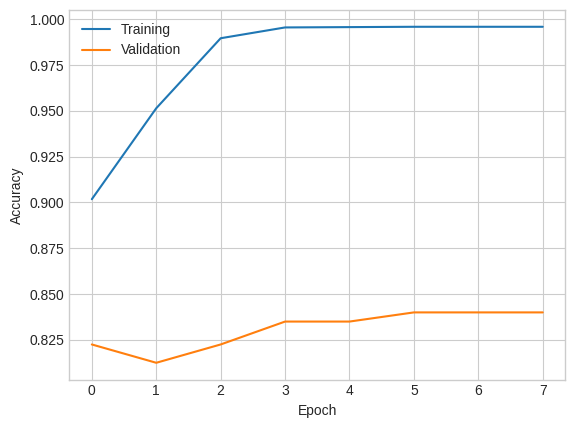

In [34]:
plt.style.use('seaborn-whitegrid')
plt.plot(accuracies['Epoch'], accuracies["Training"], label="Training")
plt.plot(accuracies['Epoch'], accuracies["Validation"], label="Validation")

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.legend()

plt.savefig("results/bert_model_accuracy_over_epoch.png")